In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [19]:
data_ = pd.read_csv("data_lagged.csv")
df = pd.read_csv("data_vad.csv")

In [15]:
X1 = data[data["label"] == 1]["batch_id"].unique()
X2 = data[data["label"] == 2]["batch_id"].unique()
X3 = data[data["label"] == 3]["batch_id"].unique()
X1_train, X1_test = train_test_split(X1,train_size = 0.7, random_state = 42)
X2_train, X2_test = train_test_split(X2,train_size = 0.7, random_state = 42)
X3_train, X3_test = train_test_split(X3,train_size = 0.7, random_state = 42)
X_train = [*X1_train, *X2_train, *X3_train]
X_test = [*X1_test, *X2_test, *X3_test]
data_train = data[data["batch_id"].apply(lambda x: x in X_train)]
data_test = data[data["batch_id"].apply(lambda x: x in X_test)]

In [17]:
def data_separation(data, train_size):
    X1 = data[data["label"] == 1]["batch_id"].unique()
    X2 = data[data["label"] == 2]["batch_id"].unique()
    X3 = data[data["label"] == 3]["batch_id"].unique()
    X1_train, X1_test = train_test_split(X1,train_size = train_size, random_state = 42)
    X2_train, X2_test = train_test_split(X2,train_size = train_size, random_state = 42)
    X3_train, X3_test = train_test_split(X3,train_size = train_size, random_state = 42)
    X_train = [*X1_train, *X2_train, *X3_train]
    X_test = [*X1_test, *X2_test, *X3_test]
    data_train = data[data["batch_id"].apply(lambda x: x in X_train)]
    data_test = data[data["batch_id"].apply(lambda x: x in X_test)]
    return data_train, data_test

In [18]:
data_train, data_test = data_separation(data, 0.7)

In [20]:
groups = np.array(data_train['batch_id'])
idx = pd.Index(groups)
Xb = data_train.drop(['msec', 'Valence', 'Arousal', 'label', 'batch_id'], axis = 1).set_index(idx)
yb_valence = data_train.iloc[:,4:5].set_index(idx)

In [21]:
#Valence
GKF = GroupKFold(n_splits=5)
cv = GKF.split(Xb, yb_valence, groups)
params = {'max_depth' : [1, 2, 3, 4, 5, 6, 7, None], 'n_estimators':np.arange(100, 600, 100)}

grid = GridSearchCV(estimator = RandomForestRegressor(random_state = 42),
                    param_grid = params, 
                    scoring = 'r2',
                    cv = cv)

rfr_val = grid.fit(Xb, yb_valence)
rfr_val.best_params_

{'max_depth': 4, 'n_estimators': 400}

### Визуализация кривых подбора параметров для модели RandomForest для Valence

In [22]:
d = rfr_val.cv_results_
def params_from_grid(d, a):
    x = []
    y = []
    y_mean_fold = []
    for j in range(a, 40 + a, 5):
        x.append(d["params"][j]["max_depth"])
        for i in range(5):
            y.append(d["split" + str(i) + "_test_score"][j])
        y_mean_fold.append(np.array(y).mean())
        y.clear()
    return x, y_mean_fold

def params_from_grid_for_n(d, a):
    x = []
    y = []
    y_mean_fold = []
    for j in range(a, a + 5):
        x.append(d["params"][j]["n_estimators"])
        for i in range(5):
            y.append(d["split" + str(i) + "_test_score"][j])
        y_mean_fold.append(np.array(y).mean())
        y.clear()
    return x, y_mean_fold

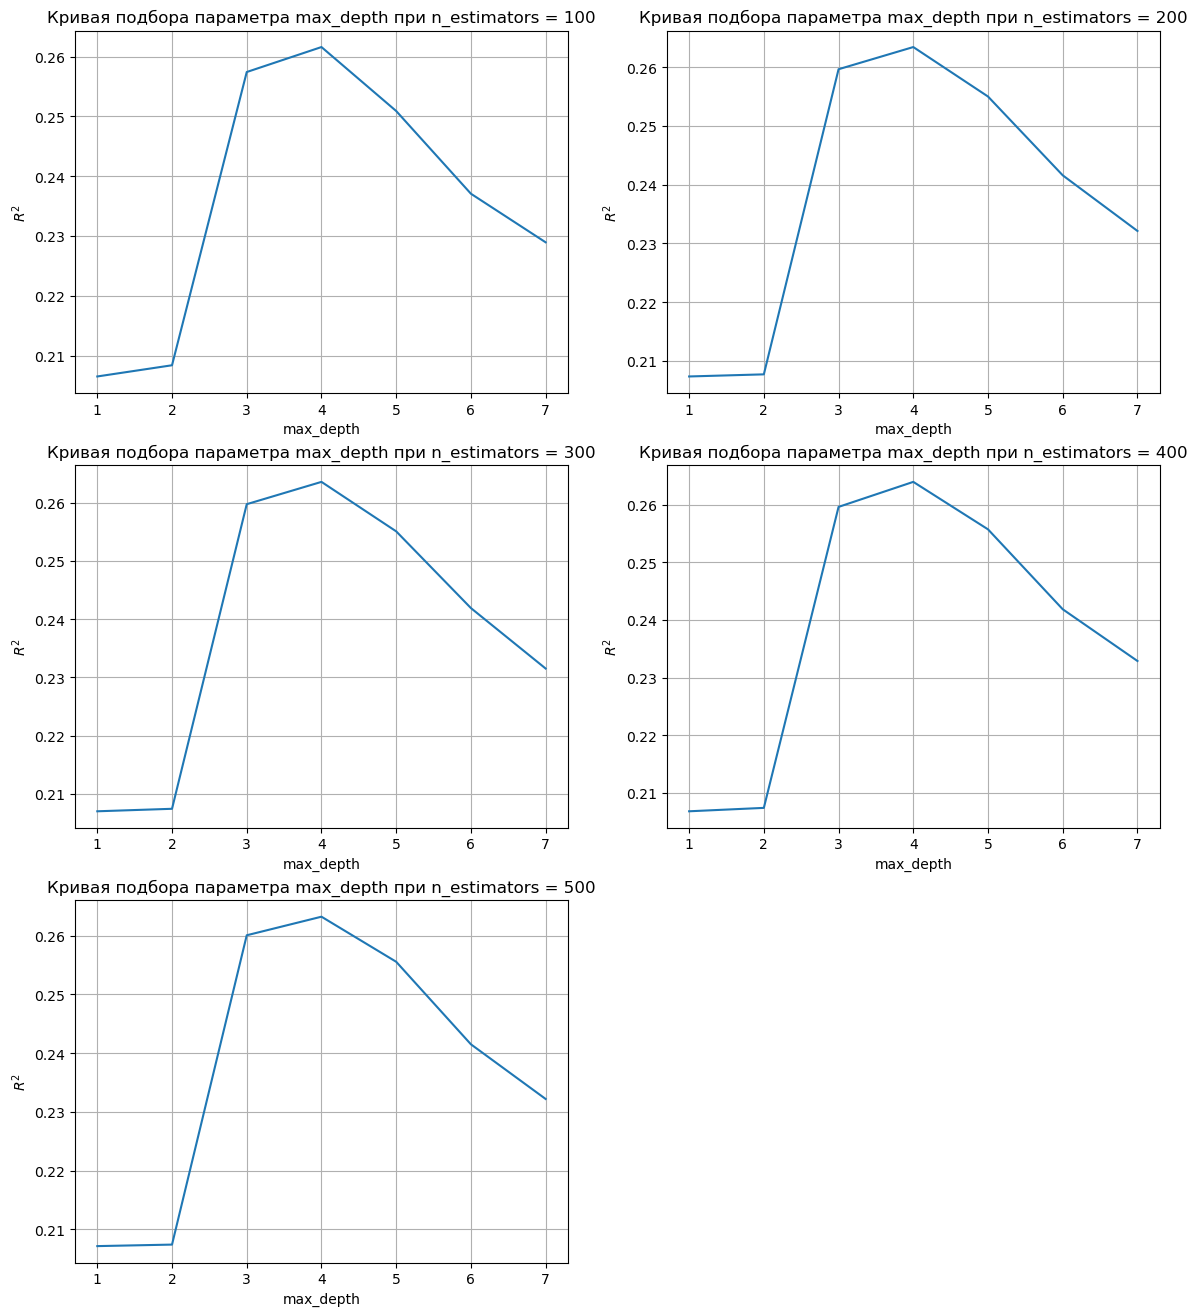

In [29]:
plt.figure(figsize=(14, 16))

plt.subplot(321)
x0, y0 = params_from_grid(d, 0)
plt.plot(x0, y0)
plt.title('Кривая подбора параметра max_depth при n_estimators = 100')
plt.xlabel('max_depth')
plt.ylabel('$R^2$')
plt.grid()

plt.subplot(322)
x1, y1 = params_from_grid(d, 1)
plt.plot(x1, y1)
plt.title('Кривая подбора параметра max_depth при n_estimators = 200')
plt.xlabel('max_depth')
plt.ylabel('$R^2$')
plt.grid()

plt.subplot(323)
x2, y2 = params_from_grid(d, 2)
plt.plot(x2, y2)
plt.title('Кривая подбора параметра max_depth при n_estimators = 300')
plt.xlabel('max_depth')
plt.ylabel('$R^2$')
plt.grid()

plt.subplot(324)
x3, y3 = params_from_grid(d, 3)
plt.plot(x3, y3)
plt.title('Кривая подбора параметра max_depth при n_estimators = 400')
plt.xlabel('max_depth')
plt.ylabel('$R^2$')
plt.grid()

plt.subplot(325)
x4, y4 = params_from_grid(d, 4)
plt.plot(x4, y4)
plt.title('Кривая подбора параметра max_depth при n_estimators = 500')
plt.xlabel('max_depth')
plt.ylabel('$R^2$')
plt.grid()

plt.show()

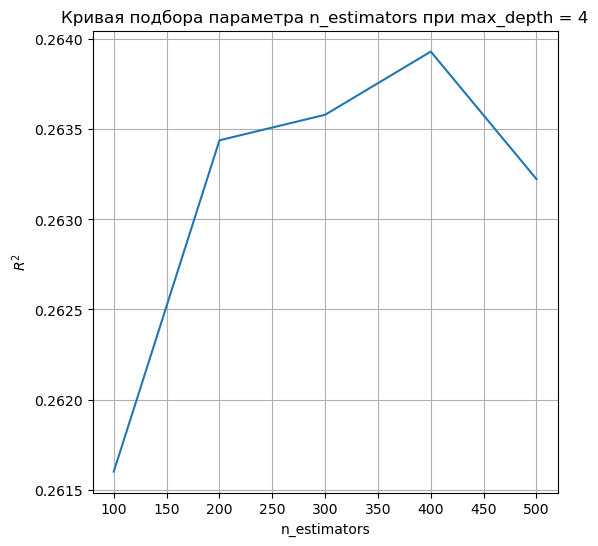

In [24]:
plt.figure(figsize=(6, 6))

x, y = params_from_grid_for_n(d, 15)
plt.plot(x, y)
plt.title('Кривая подбора параметра n_estimators при max_depth = 4')
plt.xlabel('n_estimators')
plt.ylabel('$R^2$')
plt.grid()

## Визуализация значимости признаков для RandomForest для параметра Valence на основе среднего уменьшения примеси.

In [25]:
index = data.drop(['msec', 'Valence', 'Arousal', 'label', 'batch_id'], axis = 1).columns
forest = rfr_val.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)/np.sqrt(len(forest.estimators_))
forest_importances = pd.Series(importances, index=index)

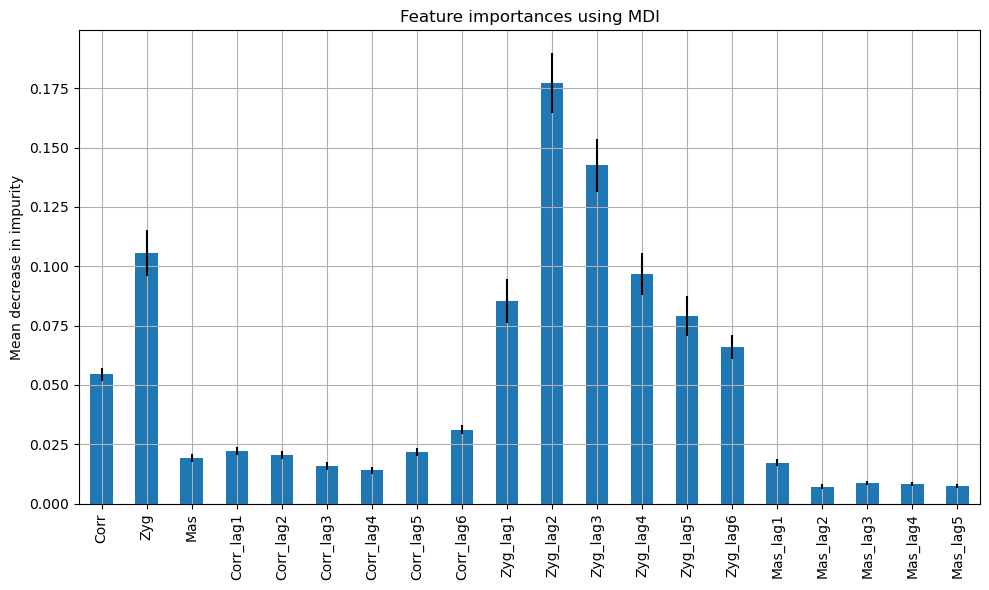

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.grid(True)
fig.tight_layout()

## Визуализация подбора параметра для лучшей модели для Arousal.

In [57]:
def params_from_grid(d):
    x = []
    y = []
    y_mean_fold = []
    for j in range(199):
        x.append(d["params"][j]['n_neighbors'])
        for i in range(5):
            y.append(d["split" + str(i) + "_test_score"][j])
        y_mean_fold.append(np.array(y).mean())
        y.clear()
    return x, y_mean_fold

In [42]:
data_train = data_separation(df.dropna(), 0.7)[0]
groups = np.array(data_train['batch_id'])
idx = pd.Index(groups)
Xb = data_train.iloc[:,1:4].set_index(idx)
yb_arousal = data_train.iloc[:,5:6].set_index(idx)

In [43]:
#Arousal
GKF = GroupKFold(n_splits=5)
cv = GKF.split(Xb, yb_arousal, groups)
params = {'n_neighbors' : np.arange(1, 200)}

grid = GridSearchCV(estimator = KNeighborsRegressor(),
                    param_grid = params, 
                    scoring = 'r2',
                    cv = cv)

knn_ar = grid.fit(Xb, yb_arousal)
knn_ar.best_params_

{'n_neighbors': 102}

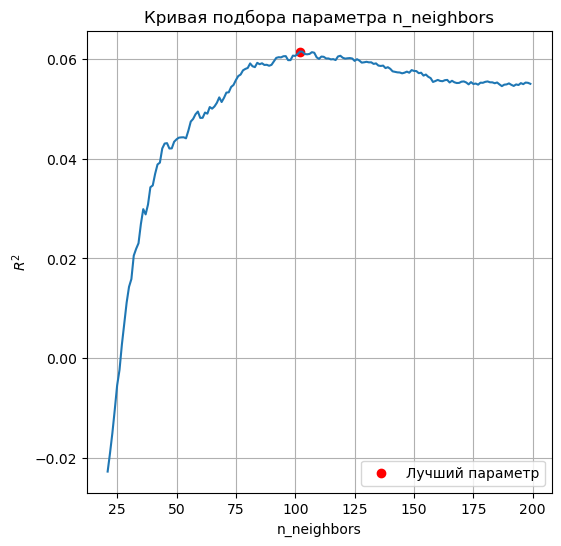

In [78]:
d_ar = knn_ar.cv_results_
x, y = params_from_grid(d_ar)

plt.figure(figsize=(6, 6))

plt.plot(x[20:], y[20:])
plt.scatter(x[101], y[101], c = 'r', label = 'Лучший параметр')
plt.title('Кривая подбора параметра n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('$R^2$')
plt.grid()
plt.legend()